In [4]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [5]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
df_weekly_sum.head(20), df_weekly_sum[df_weekly_sum['Location'] == 'Turkey'], df_weekly_sum[df_weekly_sum['Location'] == 'USA']

(   Variant                   Date                           Location  Freq
 0    Alpha  2019-12-30/2020-01-05    Africa / South Africa / Gauteng     1
 1    Alpha  2019-12-30/2020-01-05              Asia / India / Kerala     5
 2    Alpha  2019-12-30/2020-01-05          Asia / India / Tamil Nadu     1
 3    Alpha  2019-12-30/2020-01-05                            Austria     4
 4    Alpha  2019-12-30/2020-01-05                    Europe / Cyprus    21
 5    Alpha  2019-12-30/2020-01-05  Europe / United Kingdom / England   572
 6    Alpha  2019-12-30/2020-01-05                             France     2
 7    Alpha  2019-12-30/2020-01-05                              Japan     2
 8    Alpha  2019-12-30/2020-01-05                        Netherlands    30
 9    Alpha  2019-12-30/2020-01-05                                USA     9
 10   Alpha  2020-02-03/2020-02-09                              Spain     1
 11   Alpha  2020-02-24/2020-03-01                        Switzerland     1
 12   Alpha 

In [6]:
# Filter the dataframe for USA and Turkey locations and count the rows
usa_count = df_weekly_sum[df_weekly_sum['Location'] == 'USA'].shape[0]
turkey_count = df_weekly_sum[df_weekly_sum['Location'].str.contains('Turkey')].shape[0]

print(f'Total rows for USA: {usa_count}')
print(f'Total rows for Turkey: {turkey_count}')

Total rows for USA: 299
Total rows for Turkey: 142


In [9]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [10]:

# clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'Epsilon', 'Lambda', 'Iota', 'Kappa', 'Mu', 'Eta', 'Zeta', 'Theta']
# VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

# clade_input = VOC  # Update as needed

# def mix_locations(dataset, loc1, loc2, prop1, prop2):
#     df1 = dataset[dataset['Location'] == loc1].copy()
#     df2 = dataset[dataset['Location'] == loc2].copy()
    
#     df1['Freq'] = df1['Freq'] * prop1
#     df2['Freq'] = df2['Freq'] * prop2
    
#     combined_df = pd.concat([df1, df2])
    
#     combined_df = combined_df.groupby(['Variant', 'Date'], as_index=False).sum()
    
#     return combined_df

# def scatterplot(country1, country2, prop1, prop2, dataset, start, end, variant):
#     # Combine data from two locations
#     combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
#     print(combined_df.head(), combined_df.shape)

#     # Pivot dataframe so that index is date and columns are clades
#     df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq')
#     df_weekly = df_weekly.reset_index()

#     df_weekly['Collection date'] = np.random.randint(1, 6, df_weekly.shape[0])

#     # Split date column so we can retrieve month and year
#     tmp = df_weekly['Date'].str.rsplit('-', n=3, expand=True)
#     tmp.columns = ['0', '1', '2', '3']

#     # Collection date column contains month and year of each week 
#     df_weekly['Collection date'] = tmp['0']
#     cols = df_weekly.columns.tolist()
#     cols = cols[0:1] + cols[-1:] + cols[1:-1]
#     df_weekly = df_weekly[cols]

#     # Specify time frame to analyze
#     df_sum = time_frame(df_weekly, start, end)

#     # Calculate log comparisons at each week
#     df_ = clade_comparisons(df_sum)
#     df_['days'] -= df_['days'].iloc[0]

#     # Scatterplot of Omicron BA.1 lineage fitness
#     sns.set_style("white")
#     sns.set(rc={'figure.figsize': (3, 3)})

#     pango_compare = [variant]
#     marker = ['.', '+', 'v', 'x', '*']
#     legend = []
#     c = 0
#     slope_values = []

#     for i in pango_compare:
#         if i != 'Omicron':
#             mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
#             slope_values.append((f'{country1} + {country2}', slope))
#             print(slope_values)
#             sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
#         c += 1

#     plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#     plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nLocation: {country1} + {country2}', fontsize=7.5)
#     plt.xlabel('Days', fontsize=7.5)
#     plt.rc('axes', labelsize=7.5)
#     plt.rc('xtick', labelsize=7.5)
#     plt.rc('ytick', labelsize=7.5)
#     plt.gca().set_facecolor('white')
#     plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))
#     plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))

# #     # Save the figures
# #     import os

# #     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"
# #     if not os.path.exists(directory):
# #         os.makedirs(directory)

# #     filename = os.path.join(directory, f'{country1}_{country2}_regression_Omicron_vs_delta.png')
# #     plt.savefig(filename, dpi=300, bbox_inches="tight")

In [11]:
# df_weekly_sum = pd.DataFrame(data)

# Convert Date column to string first, then to datetime
df_weekly_sum['Date'] = pd.to_datetime(df_weekly_sum['Date'].astype(str).str.split('/').str[0])

clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'Epsilon', 'Lambda', 'Iota', 'Kappa', 'Mu', 'Eta', 'Zeta', 'Theta']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC  # Update as needed

def mix_locations(dataset, loc1, loc2, prop1, prop2):
    # df1 = dataset[(dataset['Location'] == loc1) & (dataset['Date'] >= '2022-03-01') & (dataset['Date'] <= '2022-05-31')].copy()
    # df2 = dataset[(dataset['Location'] == loc2) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    
    # taking the same time window for both usa and turkey
    df1 = dataset[(dataset['Location'] == loc1) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    # print(df1)
    df2 = dataset[(dataset['Location'] == loc2) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    # print(df2)
    
    df1['Freq'] = df1['Freq'] * prop1
    df2['Freq'] = df2['Freq'] * prop2
    
    combined_df = pd.concat([df1, df2])
    
    combined_df = combined_df.groupby(['Variant', 'Date'], as_index=False).sum()
    # print(combined_df)
    
    return combined_df

def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1 / clade_2)

def time_frame(df, start_date, end_date):
    df['Collection date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:, 2:] = dataframe.iloc[:, 2:].cumsum()
    for col in dataframe.columns:
        if dataframe[col].isnull().all():
            dataframe = dataframe.drop(col, axis=1)
    return dataframe

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    # Calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i, b=j)] = df.apply(lambda row: transform_ratio(row[i], row[j]), axis=1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

def scatterplot(country1, country2, prop1, prop2, dataset, start, end, variant):
    # Combine data from two locations
    combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
    # print(combined_df.head(20), combined_df.shape, combined_df['Variant'].unique())
    # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
    filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]
    # print(filtered_df.head(100), filtered_df.shape, filtered_df['Variant'].unique())

    # Pivot dataframe so that index is date and columns are clades
    df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq')
    df_weekly = df_weekly.reset_index()

    df_weekly['Collection date'] = np.random.randint(1, 6, df_weekly.shape[0])

    # Split date column so we can retrieve month and year
    tmp = df_weekly['Date'].astype(str).str.split('-', n=2, expand=True)
    tmp.columns = ['Year', 'Month', 'Day']

    # Collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['Month'] + '-' + tmp['Year']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]

    # Ensure Date column is in datetime format
    df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])

    # Specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)

    # Calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
    df_['days'] -= df_['days'].iloc[0]

    # Scatterplot of Omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc={'figure.figsize': (3, 3)})

    pango_compare = [variant]
    marker = ['.', '+', 'v', 'x', '*']
    legend = []
    c = 0
    slope_values = []

    for i in pango_compare:
        if i != 'Omicron':
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
            slope_values.append((f'{country1} + {country2}', slope))
            print(f"Slove value: {slope_values}")
            r_squared = r_value ** 2
            print(f"r-squared value: {r_squared}")
            print(f"p_value value: {p_value}")
            sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
        c += 1

    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
    plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nLocation: {country1} + {country2}', fontsize=7.5)
    plt.xlabel('Days', fontsize=7.5)
    plt.rc('axes', labelsize=7.5)
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Ensure Date column is in datetime format
# df_weekly_sum['Date'] = pd.to_datetime(df_weekly_sum['Date'])

# def mix_locations(dataset, loc1, loc2, prop1, prop2):
#     df1 = dataset[(dataset['Location'] == loc1) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
#     df2 = dataset[(dataset['Location'] == loc2) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    
#     df1['Freq'] = df1['Freq'] * prop1
#     df2['Freq'] = df2['Freq'] * prop2
    
#     combined_df = pd.concat([df1, df2])
    
#     # Aggregate to handle potential duplicate entries
#     combined_df = combined_df.groupby(['Variant', 'Date', 'Location'], as_index=False).sum()
    
#     return combined_df

# # Combine data from two locations with given proportions
# combined_df = mix_locations(df_weekly_sum, 'Turkey', 'USA', 1, 1)

# # Pivot the dataframe to have locations as columns and dates as rows
# df_pivot = combined_df.pivot_table(index='Date', columns='Location', values='Freq', aggfunc='sum', fill_value=0)

# # Plotting the stacked bar graph
# df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

# # Adding title and labels
# plt.title('Frequencies of Turkey and USA by Date')
# plt.xlabel('Date')
# plt.ylabel('Frequency')
# plt.legend(title='Location')

# # Display the plot
# plt.show()


['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08486668970058073)]
r-squared value: 0.9669293885712708
p_value value: 1.939296330069115e-06


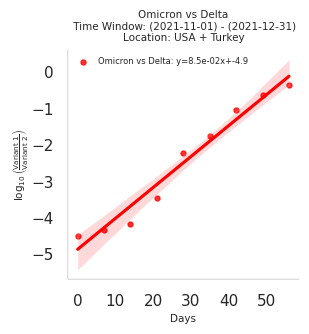

In [13]:
 scatterplot('USA', 'Turkey', 1, 1, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08487409074552013)]
r-squared value: 0.9669956331580614
p_value value: 1.9256830260003914e-06


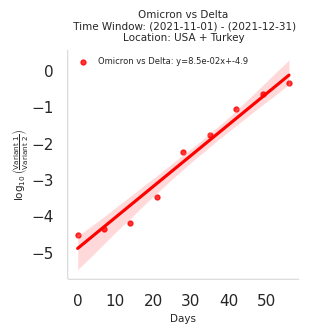

In [14]:
 scatterplot('USA', 'Turkey', 0.25, 0.75, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08486496276906927)]
r-squared value: 0.9669068226452628
p_value value: 1.9439493442778124e-06


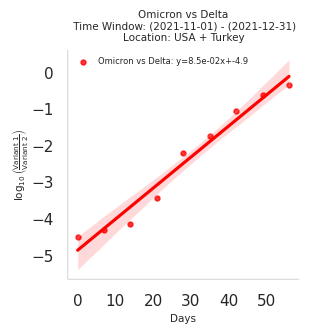

In [15]:
 scatterplot('USA', 'Turkey', 0.75, 0.25, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08491285391693174)]
r-squared value: 0.9671826497978804
p_value value: 1.8876205205548185e-06


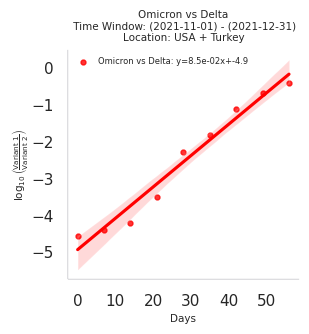

In [16]:
 scatterplot('USA', 'Turkey', 0.1, 0.9, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08486668970058073)]
r-squared value: 0.9669293885712708
p_value value: 1.939296330069115e-06


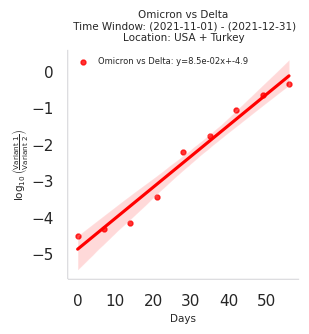

In [17]:
 scatterplot('USA', 'Turkey', 1, 1, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

['2021-11', '2021-12']
Slove value: [('USA + Turkey', 0.08486496276906927)]
r-squared value: 0.9669068226452628
p_value value: 1.9439493442778124e-06


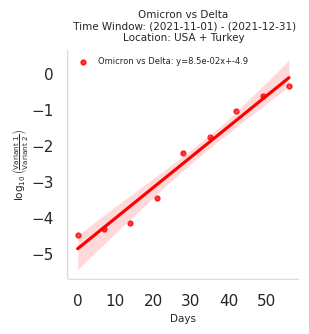

In [18]:
 scatterplot('USA', 'Turkey', 3, 1, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')

In [38]:
# # Convert Date column to string first, then to datetime
# df_weekly_sum['Date'] = pd.to_datetime(df_weekly_sum['Date'].astype(str).str.split('/').str[0])

# clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'Epsilon', 'Lambda', 'Iota', 'Kappa', 'Mu', 'Eta', 'Zeta', 'Theta']
# VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

# clade_input = VOC  # Update as needed

# def mix_locations(dataset, loc1, loc2, prop1, prop2):
#     df1 = dataset[(dataset['Location'] == loc1) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
#     df2 = dataset[(dataset['Location'] == loc2) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    
#     df1['Freq'] = df1['Freq'] * prop1
#     df2['Freq'] = df2['Freq'] * prop2
    
#     combined_df = pd.concat([df1, df2])
    
#     combined_df = combined_df.groupby(['Variant', 'Date'], as_index=False).sum()
    
#     return combined_df

# def transform_ratio(clade_1, clade_2):
#     return np.log10(clade_1 / clade_2)

# def time_frame(df, start_date, end_date):
#     df['Collection date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')
#     time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     dataframe.iloc[:, 2:] = dataframe.iloc[:, 2:].cumsum()
#     for col in dataframe.columns:
#         if dataframe[col].isnull().all():
#             dataframe = dataframe.drop(col, axis=1)
#     return dataframe

# def clade_comparisons(df):
#     clade_list = [i for i in clade_input if i in df.columns.tolist()]
#     df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
#     df['days'] = df['date_ordinal'] - 737425
#     # Calculate log ratio for each clade comparison
#     for i in clade_list:
#         for j in clade_list:
#             if i != j:
#                 df['{a} vs {b}'.format(a=i, b=j)] = df.apply(lambda row: transform_ratio(row[i], row[j]), axis=1)
#     clade_list.append('date_ordinal')
#     df = df.drop(clade_list, axis=1)
#     return df

# def scatterplot(country1, country2, proportions, dataset, start, end, variant):
#     for prop1, prop2 in proportions:
#         # Combine data from two locations with given proportions
#         combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
        
#         # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
#         filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]
#         print(f'Mixed {prop1 * 100}% {country1} + {prop2 * 100}% {country2}')
#         print(filtered_df.head(20), filtered_df.shape, filtered_df['Variant'].unique())

#         # Pivot dataframe so that index is date and columns are clades
#         df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq')
#         df_weekly = df_weekly.reset_index()

#         df_weekly['Collection date'] = np.random.randint(1, 6, df_weekly.shape[0])

#         # Split date column so we can retrieve month and year
#         tmp = df_weekly['Date'].astype(str).str.split('-', n=2, expand=True)
#         tmp.columns = ['Year', 'Month', 'Day']

#         # Collection date column contains month and year of each week 
#         df_weekly['Collection date'] = tmp['Month'] + '-' + tmp['Year']
#         cols = df_weekly.columns.tolist()
#         cols = cols[0:1] + cols[-1:] + cols[1:-1]
#         df_weekly = df_weekly[cols]

#         # Ensure Date column is in datetime format
#         df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])

#         # Specify time frame to analyze
#         df_sum = time_frame(df_weekly, start, end)

#         # Calculate log comparisons at each week
#         df_ = clade_comparisons(df_sum)
#         df_['days'] -= df_['days'].iloc[0]

#         # Scatterplot of Omicron BA.1 lineage fitness
#         sns.set_style("white")
#         sns.set(rc={'figure.figsize': (3, 3)})

#         pango_compare = [variant]
#         marker = ['.', '+', 'v', 'x', '*']
#         legend = []
#         c = 0
#         slope_values = []

#         for i in pango_compare:
#             if i != 'Omicron':
#                 mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#                 slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
#                 slope_values.append((f'{prop1 * 100}% {country1} + {prop2 * 100}% {country2}', slope))
#                 print(slope_values)
#                 sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
#             c += 1

#         plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
#         plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#         plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nLocation: {prop1 * 100}% {country1} + {prop2 * 100}% {country2}', fontsize=7.5)
#         plt.xlabel('Days', fontsize=7.5)
#         plt.rc('axes', labelsize=7.5)
#         plt.rc('xtick', labelsize=7.5)
#         plt.rc('ytick', labelsize=7.5)
#         plt.gca().set_facecolor('white')
#         plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))
#         plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))

# # Example usage with different mixing proportions
# proportions = [(0.5, 0.5), (0.75, 0.25), (0.25, 0.75)]
# scatterplot('USA', 'Turkey', proportions, df_weekly_sum, '2021-11-01', '2021-12-31', 'Delta')